In [1]:
import vaex
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter
from scipy.interpolate import interp1d
from scipy.stats import rv_continuous, norm, uniform
from scipy.integrate import simps, quad
from scipy import optimize
import emcee
import corner
from os.path import join, abspath
from os import pardir, mkdir
import seaborn as sns
import sys
import time
from multiprocessing import Pool
import os

In [2]:
# import utils
util_dir = abspath(pardir)
sys.path.insert(0, util_dir)

In [3]:
from utils import log_nu_mod

In [4]:
root_data_dir = abspath(join(pardir, "Data"))
root_data_dir

'/home2/s20321005/Thesis-Project/Data'

In [ ]:
data_baryon_dir = join(root_data_dir, "Baryon")
data_number_dir = join(root_data_dir, "Number-Density")
data_velocity_dir = join(root_data_dir, "Spectral-Class-Velocity")
data_comp_dir = join(root_data_dir, "Effective-Volume")

In [6]:
# load baryons components
df_baryon = vaex.open(join(data_baryon_dir, "baryon.hdf5"))
df_baryon

#,components,rho,e_rho,sigma_z,e_sigma_z
0,Molecular gas (H2),0.0104,0.00312,3.7,0.2
1,Cold atomic gas (HI(1)),0.0277,0.00554,7.1,0.5
2,Warm atomic gas (HI(2)),0.0073,0.0007,22.1,2.4
3,Hot ionized gas (HII),0.0005,3e-05,39.0,4.0
4,Giant stars,0.0006,6e-05,15.5,1.6
...,...,...,...,...,...
7,4 < MV < 5,0.0029,0.00029,18.0,1.8
8,5 < MV < 8,0.0072,0.00072,18.5,1.9
9,MV > 8,0.0216,0.0028,18.5,4.0
10,White dwarfs,0.0056,0.001,20.0,5.0


# 1. Constant Density

In [7]:
density = 50 # star/pc

zmax = 100 # pc

z = np.linspace(-zmax, zmax, 10) # pc
N = int(2*zmax*density)
zz = uniform.rvs(size=N)*2*zmax - zmax

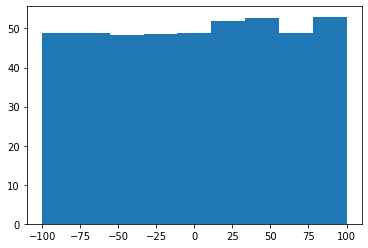

In [5]:
plt.hist(zz, bins=z,weights=np.ones_like(zz)/(z[1]-z[0]))
plt.show()

In [6]:
def log_likelihood(theta, z):
    def lambda_f(x):
        return np.ones((len(x), len(theta)))*theta
    # log_lambda = np.log(theta)*len(z)
    log_lambda = np.sum(np.log(lambda_f(z)), axis=0)
    integral = (np.max(z)-np.min(z))*theta
    return log_lambda - integral

def log_prior(theta):
    result = uniform.logpdf(theta, 0, 100)
    return result

def log_posterior(theta, z):
    prior = log_prior(theta)
    likelihood = log_likelihood(theta, z)
    result = prior + likelihood
    finite = np.isinf(prior)
    result[finite] = -np.inf
    # print(result+7000)
    return result
    

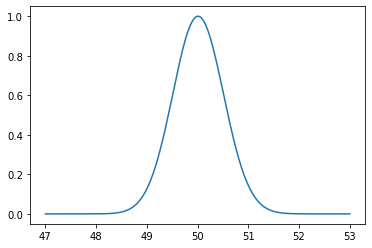

In [7]:
theta = np.linspace(47, 53, 1000)
posterior = log_posterior(theta, zz)
posterior = np.exp(posterior - np.max(posterior))
plt.plot(theta, posterior)


In [162]:
theta[np.argmax(posterior)]

50.003003003003

Optimization terminated successfully.
         Current function value: -0.797734
         Iterations: 16
         Function evaluations: 32


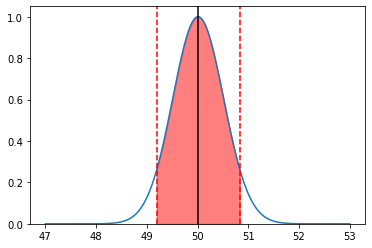

[50.00900901]
[0.8180731]
[0.82710311]


In [81]:
xmax, lower, upper = inference_bayesian(posterior, theta, hdi=0.9)
plt.plot(theta, posterior)
plt.axvline(lower, color='r', ls="--")
plt.axvline(upper, color='r', ls="--")
plt.fill_between(theta, posterior, where=(theta>lower)&(theta<upper), color='r', alpha=0.5)
plt.axvline(xmax, color='k')
# plt.axhline(0)
plt.ylim(0)
plt.show()
print(xmax)
print(xmax-lower)
print(upper-xmax)

# 2. Gaussian Density

N:  1000
sigma:  19.947114020071634


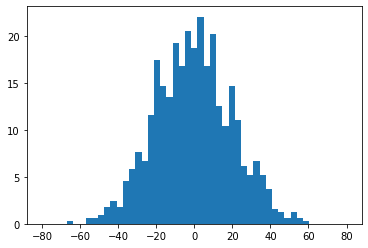

In [94]:
sigma = 20 # pc
N = 1000
density = N/np.sqrt(2*np.pi*sigma**2)
print("N: ", N)
print("sigma: ", density)

z = np.linspace(-4*sigma, 4*sigma, 50) # pc

zz = norm.rvs(loc=0, scale=sigma, size=N)

plt.hist(zz, bins=z, weights=np.ones_like(zz)/(z[1]-z[0]))
plt.show()

In [95]:
def log_likelihood(theta, z):
    args = ('sigma', 'N')
    sigma, N = itemgetter(*args)(theta)
    def lambda_f(x):
        return norm.pdf(x, loc=0, scale=sigma)*N
    log_lambda = np.sum(np.log(lambda_f(z)), axis=0)
    zz = np.linspace(np.min(z), np.max(z), 1000)
    integral = simps(lambda_f(zz), zz)
    return log_lambda - integral

def log_prior(theta, priors):
    args = ('sigma', 'N')
    sigma, N = itemgetter(*args)(theta)
    args = ('locs', 'scales')
    locs, scales = itemgetter(*args)(priors)
     
    uni_loc = np.array([locs['sigma'], locs['N']])
    uni_scale = np.array([scales['sigma'], scales['N']])
    uni_val = sigma, N
    # print(uni_val)
    log_uni = np.sum(uniform.logpdf(uni_val, loc=uni_loc, scale=uni_scale))
    return log_uni

def log_posterior(x, z, priors):
    theta = dict(sigma=x[0], N=x[1])
    prior = log_prior(theta, priors)
    if np.isinf(prior):
        return -np.inf
    likelihood = log_likelihood(theta, z)
    result = prior + likelihood
    return result

In [96]:
sigma = np.linspace(17, 23, 100)
N = np.linspace(900, 1100, 150)
locs=dict(sigma=10, N=500)
scales=dict(sigma=20, N=1000)
priors = dict(locs=locs, scales=scales)
posterior = np.zeros((len(sigma), len(N)))
for i, s in enumerate(sigma):
    for j, n in enumerate(N):
        theta = [s, n]
        posterior[i,j] = log_posterior(theta, zz, priors)
    print(i, end=" ")
posterior = np.exp(posterior - np.max(posterior))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

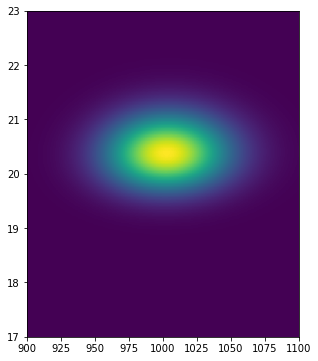

In [98]:
fig, ax = plt.subplots(figsize=(6,6))

ax.imshow(posterior, origin='lower', extent=[np.min(N), np.max(N), np.min(sigma), np.max(sigma)])
ax.set_aspect(40)

# 3. Gaussian 3 parameters with emcee

N:  1000
sigma:  19.947114020071634
loc:  -15


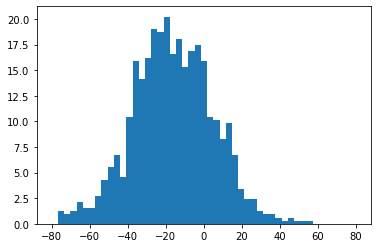

In [7]:
sigma = 20 # pc
loc = -15
N = 1000
density = N/np.sqrt(2*np.pi*sigma**2)
print("N: ", N)
print("sigma: ", density)
print("loc: ", loc)

z = np.linspace(-4*sigma, 4*sigma, 50) # pc

zz = norm.rvs(loc=loc, scale=sigma, size=N)

plt.hist(zz, bins=z, weights=np.ones_like(zz)/(z[1]-z[0]))
plt.show()

In [8]:
def log_likelihood(theta, z):
    args = ('loc', 'sigma', 'N')
    loc, sigma, N = itemgetter(*args)(theta)
    def lambda_f(x):
        return norm.pdf(x, loc=loc, scale=sigma)*N
    log_lambda = np.sum(np.log(lambda_f(z)), axis=0)
    zz = np.linspace(np.min(z), np.max(z), 1000)
    integral = simps(lambda_f(zz), zz)
    return log_lambda - integral

def log_prior(theta, priors):
    args = ('loc', 'sigma', 'N')
    loc, sigma, N = itemgetter(*args)(theta)
    args = ('locs', 'scales')
    locs, scales = itemgetter(*args)(priors)
     
    uni_loc = np.array([locs['loc'], locs['sigma'], locs['N']])
    uni_scale = np.array([scales['loc'], scales['sigma'], scales['N']])
    uni_val = loc, sigma, N
    log_uni = np.sum(uniform.logpdf(uni_val, loc=uni_loc, scale=uni_scale))
    return log_uni

def log_posterior(x, z, priors):
    theta = dict(loc=x[0], sigma=x[1], N=x[2])
    prior = log_prior(theta, priors)
    if np.isinf(prior):
        return -np.inf
    likelihood = log_likelihood(theta, z)
    result = prior + likelihood
    return result

In [9]:
ndim = 3
nwalkers = ndim*2+10


loc_loc, loc_scale = -50, 60
loc_0 = np.random.uniform(low=loc_loc, high=loc_loc+loc_scale, size=nwalkers)

sigma_loc, sigma_scale = 10, 20
sigma_0 = np.random.uniform(low=sigma_loc, high=sigma_loc+sigma_scale, size=nwalkers)

N_loc, N_scale = 700, 500
N_0 = np.random.uniform(low=N_loc, high=N_loc+N_scale, size=nwalkers)

p0 = np.array([loc_0, sigma_0, N_0]).T

In [10]:
locs = dict(loc=loc_loc, sigma=sigma_loc, N=N_loc)

scales = dict(loc=loc_scale, sigma=sigma_scale, N=N_scale)
priors = dict(locs=locs, scales=scales)
data = zz
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[data, priors])

In [11]:
state = sampler.run_mcmc(p0, 200, progress=True)
state

100%|██████████| 200/200 [00:06<00:00, 32.40it/s]


State([[ -15.60812654   21.13879058  966.48488734]
 [ -16.40180138   21.87518982  994.206594  ]
 [ -16.46459764   21.18981868  981.95188879]
 [ -16.40217887   20.46779819 1003.70981999]
 [ -15.49030744   21.63532524 1006.67147884]
 [ -15.4487834    21.52947429  997.78530929]
 [ -16.36418322   21.60364943 1047.75700147]
 [ -17.79718873   21.63384285 1026.43937641]
 [ -15.57784918   22.05414017 1037.51526394]
 [ -17.43747807   21.4638673  1025.8508636 ]
 [ -17.38875561   21.23932503 1058.60495653]
 [ -16.34532642   21.22336064 1038.65607821]
 [ -16.50607239   20.70965164  961.41899581]
 [ -17.08249595   21.18021155  978.37141535]
 [ -16.93564257   21.92538106 1097.2970513 ]
 [ -15.24611319   21.09856072 1045.07670199]], log_prob=[1426.09672978 1427.03706178 1427.11148457 1425.54823275 1426.61204096
 1426.59635527 1426.43669972 1424.92925223 1425.55951943 1425.91898639
 1424.6814246  1426.75225832 1425.52467852 1426.40275047 1422.58420313
 1425.11761695], blobs=None, random_state=('MT1993

Text(0.5, 0, 'step number')

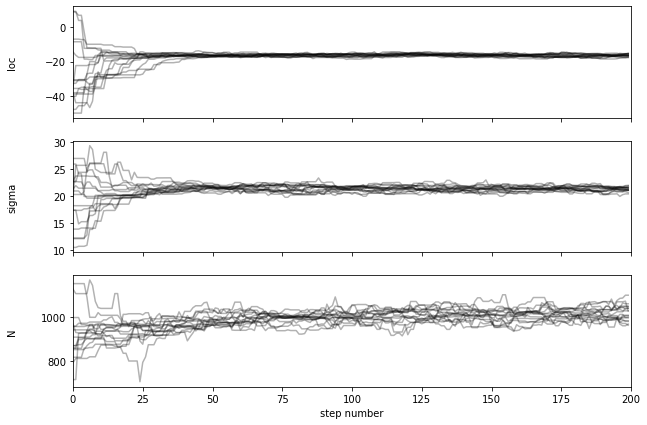

In [12]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["loc", "sigma", "N",]
for i in range(3):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [13]:
sampler.reset()
sampler.run_mcmc(state, 5000, progress=True)

100%|██████████| 5000/5000 [02:22<00:00, 34.99it/s]


State([[ -15.47166114   21.81495262  985.58455365]
 [ -17.39866064   21.17419517  996.38619181]
 [ -16.95753964   22.15430283 1004.21049526]
 [ -16.57298186   21.68384928  999.86781466]
 [ -16.95362793   20.81129478 1008.06115577]
 [ -16.89318238   21.26294837 1005.94877997]
 [ -16.58887483   21.08407237 1030.76430285]
 [ -15.32967192   22.02571103 1074.51800027]
 [ -16.62490137   20.48647484 1009.50057844]
 [ -15.24832448   20.83046471  993.03515104]
 [ -14.56052938   22.09367483 1005.35439418]
 [ -16.1605272    21.06463643 1030.89968328]
 [ -15.85687565   20.7860976   993.01683862]
 [ -15.04246793   21.1224442  1021.9878998 ]
 [ -16.00478109   20.90810464 1039.43971775]
 [ -16.59701107   22.16038926 1002.61713641]], log_prob=[1426.2264304  1426.04325347 1426.17075143 1427.27046555 1426.20665567
 1427.05141016 1426.76213101 1423.33370864 1425.4790993  1425.46775682
 1423.40063891 1426.78663165 1426.38068    1425.32092235 1426.159796
 1426.43964124], blobs=None, random_state=('MT19937'

Text(0.5, 0, 'step number')

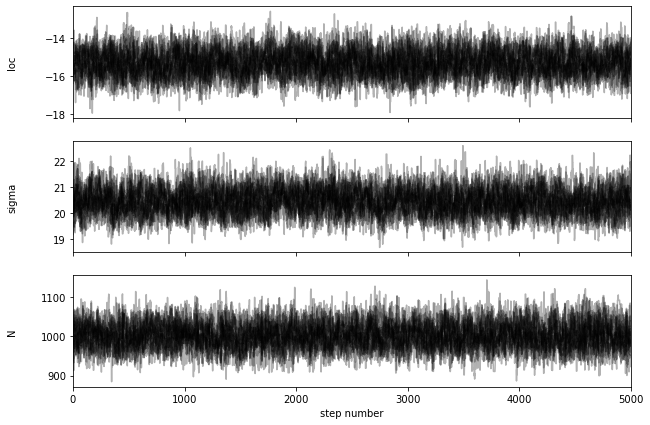

In [108]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["loc", "sigma", "N"]
for i in range(3):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [109]:
flat_samples = sampler.get_chain(flat=True)
flat_samples

array([[ -14.22564726,   20.25298152,  938.18810803],
       [ -15.14447163,   20.36204576,  984.50972342],
       [ -15.91145349,   20.01913768,  981.52134291],
       ...,
       [ -14.73135813,   20.25676801,  991.67679608],
       [ -13.97870808,   21.27109377,  976.15043003],
       [ -15.18920701,   19.96595604, 1015.94638106]])

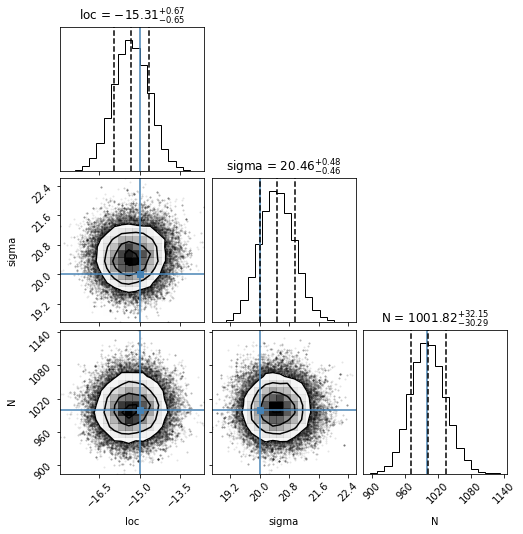

In [112]:
fig = corner.corner(
    flat_samples, labels=["loc", "sigma", "N"],
    truths=[loc, sigma, N],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True, title_kwargs={"fontsize": 12},
    
)

In [7]:
class quadratic_gen(rv_continuous):
    "Quadratic distribution"
    def _pdf(self, x):
        return np.piecewise(x, [ np.abs(x-0.5) > 0.5, np.abs(x-0.5) <= 0.5 ], [lambda t: 0, lambda t: 3*t**2])
    def _cdf(self, x):
        return np.piecewise(x, [ np.abs(x-0.5) > 0.5, np.abs(x-0.5) <= 0.5 ], [lambda t: 0, lambda t: t**3])
    def _logpdf(self, x):
        return np.piecewise(x, [ np.abs(x-0.5) >= 0.5, np.abs(x-0.5) < 0.5 ], [lambda t: -np.inf, lambda t: np.log(3*t**2)])
quadratic = quadratic_gen(name="quadratic")  

class square_gen(rv_continuous):
    "square root distribution"
    def _pdf(self, x):
        return np.piecewise(x, [ np.abs(x-0.5) > 0.5, np.abs(x-0.5) <= 0.5 ], [lambda t: 0, lambda t: 3/2*np.sqrt(t)])
    def _cdf(self, x):
        return np.piecewise(x, [ np.abs(x-0.5) > 0.5, np.abs(x-0.5) <= 0.5 ], [lambda t: 0, lambda t: t**(3/2)])
    def _logpdf(self, x):
        return np.piecewise(x, [ np.abs(x-0.5) >= 0.5, np.abs(x-0.5) < 0.5 ], [lambda t: -np.inf, lambda t: np.log(3/2*np.sqrt(t))])
square = square_gen(name="square")  

# 4. Modelling number density with 1 parameter

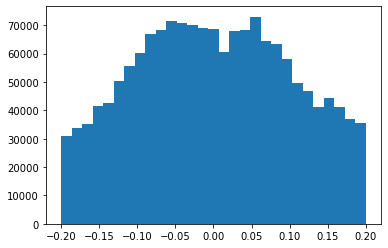

21889


In [41]:
# get a grasp of the distribution
tipe = "F"
df_number = vaex.open(join(data_number_dir, f"cum-{tipe}.hdf5"))

zz = np.linspace(-0.2, 0.2, 30)
z = df_number.z.to_numpy()
plt.hist(z, bins=zz, weights=np.ones_like(z)/(zz[1]-zz[0]))
plt.show()
print(len(z))

approximately 12000 star/pc

## Model

In [57]:
# convenient function
def hdi_interval(func, a, b, ymax, xmax, std, level=10, hdi=0.68):
    yup = ymax*0.999
    ydown = 0
    lower = a
    upper = b
    for i in range(level):
        dy = (yup-ydown)/10
        for ynew in np.arange(yup, ydown, -dy):
            sol = optimize.root(lambda y: func(y) - ynew, [xmax-std, xmax+std])
            area = quad(func, sol.x[0], sol.x[1])[0]
            if area > hdi:
                yup = ynew+dy
                ydown = ynew
                lower = sol.x[0]
                upper = sol.x[1]
                break
    return lower, upper

def inference_bayesian(post, x, hdi=0.68, level=10):
    interp_raw = interp1d(x, post, kind='cubic', fill_value='extrapolate')
    norm = np.trapz(interp_raw(x), x)
    interp = lambda x: interp_raw(x)/norm
    xmax = optimize.fmin(lambda x: -1*interp(x), x[np.argmax(interp(x))])
    mean = quad(lambda x: x*interp(x), np.min(x), np.max(x))[0]
    std = np.sqrt(quad(lambda x: (x-mean)**2*interp(x), np.min(x), np.max(x))[0])
    lower, upper = hdi_interval(interp, x[0], x[-1], interp(xmax), xmax, std, level=level, hdi=hdi)
    return xmax, lower, upper

def plot_chain(sampler, labels, skip=0):
    fig, axs = plt.subplots(len(labels), figsize=(10, 7), sharex=True)
    axes = axs if len(labels) > 1 else [axs]
    samples = sampler.get_chain()
    for i in range(len(labels)):
        ax = axes[i]
        ax.plot(samples[:, :, skip+i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)
    axes[-1].set_xlabel("step number")
def plot_corners(flat_samples, labels, skip=0, **kwargs):
    ks = dict(
        labels=labels,
        quantiles=[0.16, 0.5, 0.84],
        show_titles=True, 
        title_kwargs={"fontsize": 12},
        title_fmt = '.3f'
    )
    if 'truths' in kwargs:
        ks['truths'] = kwargs['truths']
    fig = corner.corner(flat_samples[:, skip:], **ks)

def plot_compare(data, model, total, theta, logNu_, it=2000):
    z_num, zz = itemgetter('z_num', 'zz')(data)
    start = time.time()
    for i in range(it):
        index = int(np.random.random()*total)
        for k, v in model.items():
            theta[k] = v[index]
        # logNu = log_nu_mod(zz, theta)+np.log(compz(zz))
        logNu = logNu_(zz, theta)
        plt.plot(zz, np.exp(logNu), c="red", alpha=0.005)
    plt.hist(z_num, bins=zz, weights=np.ones_like(z_num)/(zz[1]-zz[0]))
    plt.show()
    end = time.time()
    print(end-start)

In [42]:
def cumulative(z, theta, compz):
    nu_f = lambda zz: np.exp(log_nu_mod(zz, theta))/theta["Nu0"]*compz(zz)
    zz = np.linspace(-1,1, 1000)
    integral = simps(nu_f(zz), zz)
    zz = np.array([np.linspace(-1, zs, 1000) for zs in z])
    result = np.array([simps(nu_f(zs), zs) for zs in zz])/integral
    return result

def mock_stars(theta, compz):
    # logNu
    zz = np.linspace(-0.2, 0.2, 50)
    logNu = log_nu_mod(zz, theta)
    plt.plot(zz, logNu)
    plt.show()
    # completeness function
    plt.plot(zz, compz(zz))
    plt.ylim(0, 1)
    plt.grid()
    plt.show()
    # normalization
    nu_f = lambda zz: np.exp(log_nu_mod(zz, theta))/theta["Nu0"]*compz(zz)
    plt.plot(zz, nu_f(zz))
    plt.show()
    integral_nu, _ = quad(nu_f, -1, 1)
    print("1/integral:", 1/integral_nu)
    # generate random stars distribution
    invers = interp1d(cumulative(zz, theta, compz), zz, kind="cubic", fill_value="extrapolate")
    Num = int(theta['Nu0']*integral_nu)
    rand = np.random.random(Num)
    print("Num of stars: ", Num)
    z_num = invers(rand)
    plt.hist(z, bins=zz, weights=np.ones_like(z)/(zz[1]-zz[0]))
    plt.hist(z_num, bins=zz, weights=np.ones_like(z_num)/(zz[1]-zz[0]), label="mock", color='red', alpha=0.5)
    plt.legend()
    plt.show()
    # compare with real distribution
    plt.plot(zz, cumulative(zz, theta, compz))
    plt.plot(np.sort(z_num), np.linspace(0,1, len(z_num)))
    plt.show()
    # stars velocity distribution
    w_num = norm.rvs(loc=theta['w0'], scale=theta['sigma_w'], size=theta['N0'])
    ws = np.linspace(-25, 15, 30)
    plt.hist(w_num, bins=ws, weights=np.ones_like(w_num)/(ws[1]-ws[0]))
    plt.show()
    return zz, z_num, w_num

In [61]:
rhos = df_baryon['rho'].to_numpy()
e_rhos = df_baryon['e_rho'].to_numpy()
sigmaz = df_baryon['sigma_z'].to_numpy()
e_sigmaz = df_baryon['e_sigma_z'].to_numpy()

# test the following dark values
rhoDM = 0.016 # Msun/pc^3
sigmaDD = 2 # Msun/pc^2
hDD = 20 # pc
Nu0 = 110000 # pc^-1
zsun = 0.001 # kpc
sigma_w = 10 # km/s
w0 = -7 # km/s
R = 3.4E-3 # Msun/pc^3
N0 = 500 # (km/s)^-1
theta = dict(rhos=rhos, sigmaz=sigmaz, rhoDM=rhoDM, sigmaDD=sigmaDD, hDD=hDD, Nu0=Nu0, zsun=zsun, R=R, sigma_w=sigma_w, w0=w0, N0=N0)
# compz = lambda x: -0.04*norm.pdf(x, loc=0, scale=0.035)+0.8
df_comp = vaex.open(join(data_comp_dir, "comp.hdf5"))

comp = df_comp[tipe].to_numpy()
zz = df_comp.z.to_numpy()
compz = interp1d(zz, comp, kind='cubic', fill_value='extrapolate')

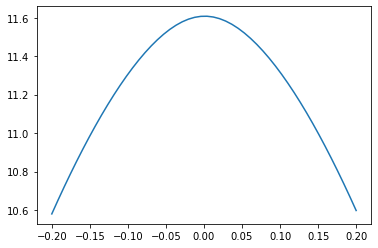

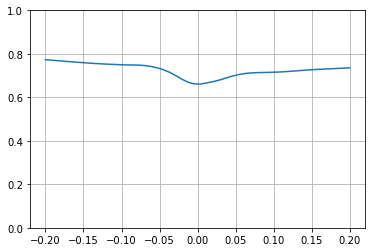

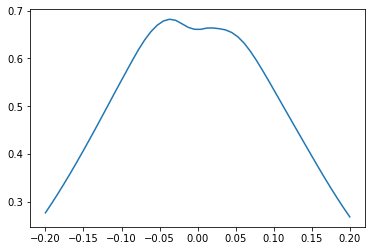

1/integral: 3.5866706602018485
Num of stars:  30669


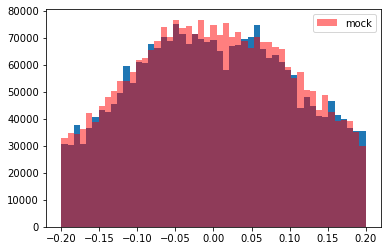

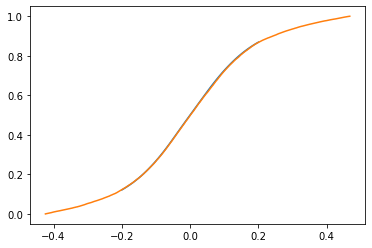

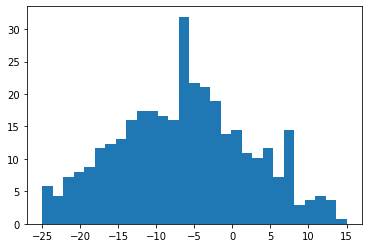

In [62]:
zz, z_num, w_num = mock_stars(theta, compz)

In [63]:
def log_prior(theta, locs, scales):
    args = ('Nu0',)
    Nu0 = itemgetter(*args)(theta)
    args = ('Nu0_loc', )
    Nu0_loc = itemgetter(*args)(locs)
    args = ('Nu0_scale',)
    Nu0_scale = itemgetter(*args)(scales)
    uni_loc = np.array([Nu0_loc])
    uni_scale = np.array([Nu0_scale])
    uni_val =  Nu0
    log_uni = np.sum(uniform.logpdf(uni_val, loc=uni_loc, scale=uni_scale))
    result = (log_uni)
    return result

def log_likelihood(theta, z):
    nu_f = lambda zz: np.exp(log_nu_mod(zz, theta))*compz(zz)
    zz = np.linspace(np.min(z), np.max(z), 1000)  
    integral_nu = simps(nu_f(zz), zz)
    log_nu = np.sum(log_nu_mod(z, theta)+np.log(compz(z)))
    return log_nu-integral_nu

def log_posterior(x, priors, data):
    theta = dict(rhos=rhos, sigmaz=sigmaz, rhoDM=rhoDM, sigmaDD=sigmaDD, hDD=hDD, Nu0=x[0], zsun=zsun, R=R, sigma_w=sigma_w, w0=w0, N0=N0)
    locs, scales = itemgetter('locs', 'scales')(priors)
    z = itemgetter('z')(data)
    log_prior_ = log_prior(theta, locs, scales)
    if not np.isfinite(log_prior_):
        return -np.inf
    log_likelihood_ = log_likelihood(theta, z)
    return log_prior_ + log_likelihood_

In [64]:
ndim = 1
nwalkers = ndim*3

Nu0_loc, Nu0_scale = 90000, 40000
Nu0_0 = np.random.uniform(low=Nu0_loc, high=Nu0_loc+Nu0_scale, size=nwalkers)

p0 = np.array([Nu0_0]).T

In [65]:
locs = dict(Nu0_loc=Nu0_loc)
scales = dict(Nu0_scale=Nu0_scale)
priors = dict(locs=locs, scales=scales)
data = dict(z=z_num)

100%|██████████| 100/100 [00:08<00:00, 11.77it/s]


Multiprocessing took 8.6 seconds


100%|██████████| 5000/5000 [07:04<00:00, 11.78it/s]


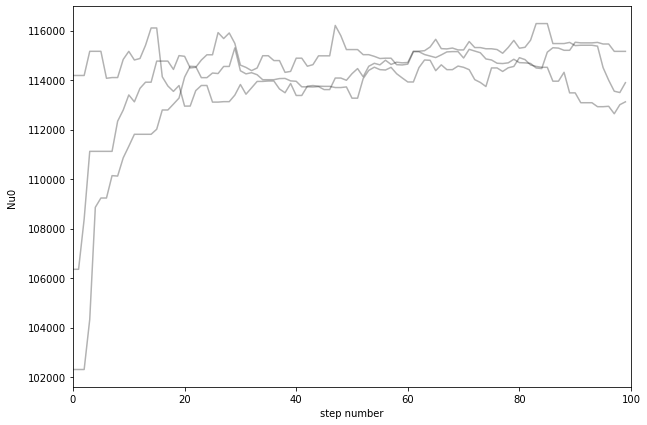

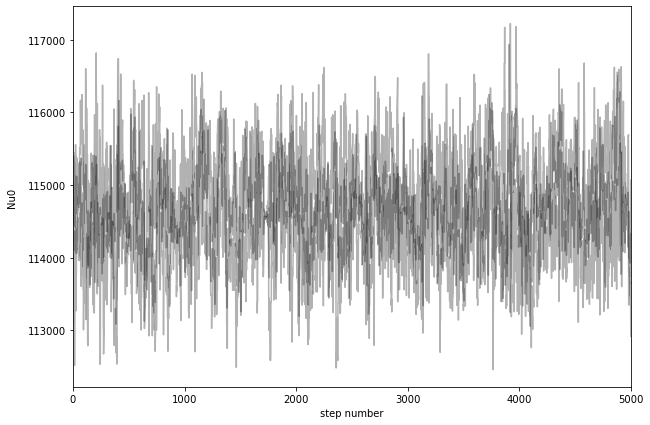

In [66]:
os.environ["OMP_NUM_THREADS"] = "16"
sampler_ = 0
labels = ["Nu0"]
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[priors, data], pool=pool)
    start = time.time()
    state = sampler.run_mcmc(p0, 100, progress=True)
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    plot_chain(sampler, labels)
    sampler.reset()
    sampler.run_mcmc(state, 5000, progress=True)
    plot_chain(sampler, labels)
    sampler_ = sampler

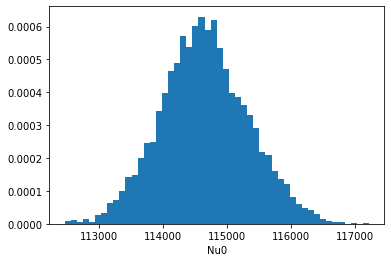

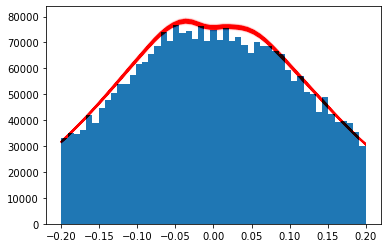

15.359433889389038


In [67]:
flat_samples = sampler_.get_chain(flat=True)
# plot_corners(flat_samples, labels, skip=0, truths=[rhoDM, sigmaDD, hDD, Nu0 ])
plt.hist(flat_samples[:,0], bins=50, density=True)
plt.xlabel("Nu0")
plt.show()

model = dict(
    Nu0=flat_samples[:, 0],
)
total = len(flat_samples[:, 0])
data = dict(z_num=z_num, zz=zz)

plot_compare(data, model, total, theta, lambda x, t: log_nu_mod(x, t)+np.log(compz(x)))

In [201]:
# log_post_norm = log_post - np.max(log_post)
# post = np.exp(log_post_norm)

# xmax, lower, upper  = inference_bayesian(post, Nu0s, 0.68)

# plt.plot(Nu0s, post)
# plt.axvline(Nu0_real, color="red")
# plt.axvline(xmax, color="green")
# plt.axvline(lower, color="green", linestyle="--")
# plt.axvline(upper, color="green", linestyle="--")
# print("real: ", Nu0_real)
# print(xmax)
# print(xmax-lower)
# print(upper-xmax)

# 4. Modelling number density with 2 parameter

In [ ]:
def log_prior(theta, locs, scales):
    args = ('rhoDM', 'Nu0')
    rhoDM, Nu0 = itemgetter(*args)(theta)
    args = ('rhoDM_loc', 'Nu0_loc')
    rhoDM_loc, Nu0_loc = itemgetter(*args)(locs)
    args = ('rhoDM_scale', 'Nu0_scale')
    rhoDM_scale, Nu0_scale = itemgetter(*args)(scales)
    uni_loc = np.array([Nu0_loc ])
    uni_scale = np.array([Nu0_scale])
    uni_val =  Nu0,
    log_uni = np.sum(uniform.logpdf(uni_val, loc=uni_loc, scale=uni_scale))
    result = (log_uni+ quadratic.logpdf(rhoDM, loc=rhoDM_loc, scale=rhoDM_scale))
    return result

def log_likelihood(theta, z):
    nu_f = lambda zz: np.exp(log_nu_mod(zz, theta))*compz(zz)
    zz = np.linspace(np.min(z), np.max(z), 1000)  
    integral_nu = simps(nu_f(zz), zz)
    log_nu = np.sum(log_nu_mod(z, theta)+np.log(compz(z)))
    return log_nu-integral_nu

def log_posterior(x, priors, data):
    theta = dict(rhos=rhos, sigmaz=sigmaz, rhoDM=x[0], sigmaDD=sigmaDD, hDD=hDD, Nu0=x[1], zsun=zsun, R=R, sigma_w=sigma_w, w0=w0, N0=N0)
    locs, scales = itemgetter('locs', 'scales')(priors)
    z = itemgetter('z')(data)
    log_prior_ = log_prior(theta, locs, scales)
    if not np.isfinite(log_prior_):
        return -np.inf
    log_likelihood_ = log_likelihood(theta, z)
    return log_prior_ + log_likelihood_

In [206]:
ndim = 2
nwalkers = ndim*3

rhoDM_loc, rhoDM_scale = 0, 0.06
rhoDM_0 = np.random.uniform(low=rhoDM_loc, high=rhoDM_loc+rhoDM_scale, size=nwalkers)

Nu0_loc, Nu0_scale = 24000, 12000
Nu0_0 = np.random.uniform(low=Nu0_loc, high=Nu0_loc+Nu0_scale, size=nwalkers)

p0 = np.array([rhoDM_0, Nu0_0]).T

In [207]:
locs = dict(rhoDM_loc=rhoDM_loc, Nu0_loc=Nu0_loc)
scales = dict(rhoDM_scale=rhoDM_scale, Nu0_scale=Nu0_scale)
priors = dict(locs=locs, scales=scales)
data = dict(z=z_num)

In [209]:
os.environ["OMP_NUM_THREADS"] = "16"
sampler_ = 0
labels = ["rhoDM",  "Nu0",]
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[priors, data], pool=pool)
    start = time.time()
    state = sampler.run_mcmc(p0, 100, progress=True)
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    plot_chain(sampler, labels)
    sampler.reset()
    sampler.run_mcmc(state, 5000, progress=True)
    plot_chain(sampler, labels)
    sampler_ = sampler

emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:
  params:emcee: Exception while calling your likelihood function:

  params:
 emcee: Exception while calling your likelihood function:  params:[1.48854258e-02 2.89420004e+04]
    params:  params:[5.40870125e-03 2.83588018e+04]
  params:[3.66029089e-02 2.69852866e+04]    args:[5.72787456e-02 3.23956112e+04]
  [2.65308275e-02 3.17885909e+04]

  args:[1.66048274e-02 3.57289774e+04]  args:
[{'locs': {'rhoDM_loc': 0, 'Nu0_loc': 24000}, 'scales': {'rhoDM_scale': 0.06, 'Nu0_scale': 12000}}, {'z': array([-0.07783501,  0.14946698, -0.03170148, ..., -0.06050749,
        0.08870385, -0.07336292])}]  args:  
  args:[{'locs': {'rhoDM_loc': 0, 'Nu0_loc': 24000}, 'scales': {'rhoDM_scale': 0.06, 'Nu0_scale': 12000}}, {'z': array([-0.07783501,  0.14946698, -0.03170148, ..., -0.060

Traceback (most recent call last):


  File "/home2/s20321005/.conda/envs/vaex2/lib/python3.9/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
Traceback (most recent call last):


Traceback (most recent call last):


  exception:

Traceback (most recent call last):
  File "/home2/s20321005/.conda/envs/vaex2/lib/python3.9/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
Traceback (most recent call last):
  File "/home2/s20321005/.conda/envs/vaex2/lib/python3.9/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-202-bad26935ffce>", line 29, in log_posterior
    log_likelihood_ = log_likelihood(theta, z)


  File "/home2/s20321005/.conda/envs/vaex2/lib/python3.9/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-202-bad26935ffce>", line 29, in log_posterior
    log_likelihood_ = log_likelihood(theta, z)
  File "/home2/s20321005/.conda/envs/vaex2/lib/python3.9/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-202-bad26935ffce>", line 19, in log_likelihood
    log_nu = np.sum(log_nu_mod(z, theta)+np.log(compz(zz)))
Traceback (most recent call last):
  File "<ipython-input-202-bad26935ffce>", line 29, in log_posterior
    log_likelihood_ = log_likelihood(theta, z)
  File "<ipython-input-202-bad26935ffce>", line 29, in log_posterior
    log_likelihood_ = log_likelihood(theta, z)
  File "<ipython-input-202-bad26935ffce>", line 19, in log_likelihood
    log_nu = np.sum(log_nu_mod(z, theta)+np.log(compz(zz)))
  File "<ipython-input-202-bad26935

ValueError: operands could not be broadcast together with shapes (2358,) (1000,) 

In [ ]:
flat_samples = sampler_.get_chain(flat=True)
plot_corners(flat_samples, labels, skip=0, truths=[rhoDM,  Nu0])

model = dict(
    rhoDM=flat_samples[:, 0],
    Nu0=flat_samples[:, 1],
)
total = len(flat_samples[:, 0])
data = dict(z_num=z_num, zz=zz)

plot_compare(data, model, total, theta, lambda x, t: log_nu_mod(x, t)+np.log(compz(x)))

# 5. Modelling number density with 3 parameter with emcee

In [15]:
from multiprocessing import cpu_count

ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

16 CPUs


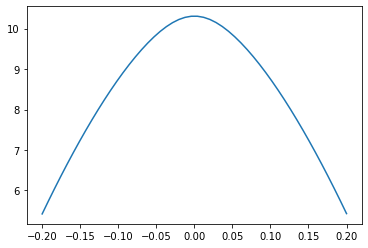

In [113]:
rhos = df_baryon['rho'].to_numpy()
e_rhos = df_baryon['e_rho'].to_numpy()
sigmaz = df_baryon['sigma_z'].to_numpy()
e_sigmaz = df_baryon['e_sigma_z'].to_numpy()

# test the following dark values
rhoDM = 0.016 # Msun/pc^3
sigmaDD = 7 # Msun/pc^2
hDD = 20 # pc
Nu0 = 30000 # pc^-1
zsun = 0.0001 # kpc
sigma_w = 5 # km/s
w0 = 0.5 # km/s
R = 3.4E-3 # Msun/pc^3
N0 = 200 # (km/s)^-1
theta = dict(rhos=rhos, sigmaz=sigmaz, rhoDM=rhoDM, sigmaDD=sigmaDD, hDD=hDD, Nu0=Nu0, zsun=zsun, R=R, sigma_w=sigma_w, w0=w0, N0=N0)

zz = np.linspace(-0.2, 0.2, 50)
logNu = log_nu_mod(zz, theta)
plt.plot(zz, logNu)

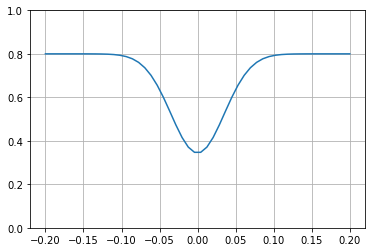

In [114]:
# completeness function
compz = lambda x: -0.04*norm.pdf(x, loc=0, scale=0.035)+0.8

plt.plot(zz, compz(zz))
plt.ylim(0, 1)
plt.grid()

12.720181473076224


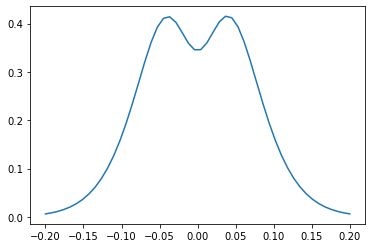

In [115]:
nu_f = lambda zz: np.exp(log_nu_mod(zz, theta))/theta["Nu0"]*compz(zz)
plt.plot(zz, nu_f(zz))
integral_nu, _ = quad(nu_f, -1, 1)
print(1/integral_nu)

In [116]:
def cumulative(z, theta):
    nu_f = lambda zz: np.exp(log_nu_mod(zz, theta))/theta["Nu0"]*compz(zz)
    zz = np.linspace(-1,1, 1000)
    integral = simps(nu_f(zz), zz)
    zz = np.array([np.linspace(-1, zs, 1000) for zs in z])
    result = np.array([simps(nu_f(zs), zs) for zs in zz])/integral
    return result

2358


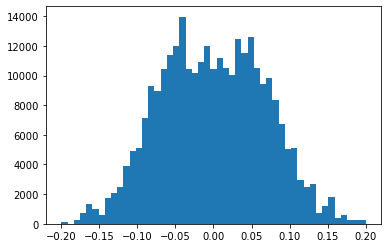

In [117]:
# generate random stars

invers = interp1d(cumulative(zz, theta), zz, kind="cubic", fill_value="extrapolate")
Num = int(Nu0*integral_nu)
rand = np.random.random(Num)
# Nu0_real = Num/integral_nu
print(Num)
z_num = invers(rand)

plt.hist(z_num, bins=zz, weights=np.ones_like(z_num)/(zz[1]-zz[0]))
plt.show()

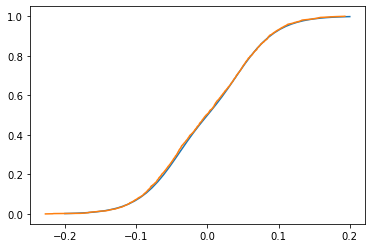

In [118]:
plt.plot(zz, cumulative(zz, theta))
plt.plot(np.sort(z_num), np.linspace(0,1, len(z_num)))

In [140]:
def log_prior(theta, locs, scales):
    args = ('rhoDM', 'sigmaDD', 'Nu0')
    rhoDM, sigmaDD, Nu0 = itemgetter(*args)(theta)
    args = ('rhoDM_loc', 'sigmaDD_loc', 'Nu0_loc')
    rhoDM_loc, sigmaDD_loc, Nu0_loc = itemgetter(*args)(locs)
    args = ('rhoDM_scale', 'sigmaDD_scale', 'Nu0_scale')
    rhoDM_scale, sigmaDD_scale, Nu0_scale = itemgetter(*args)(scales)

    # uni_loc = np.array([sigmaDD_loc, Nu0_loc])
    # uni_scale = np.array([sigmaDD_scale, Nu0_scale])
    # uni_val =  sigmaDD, Nu0

    uni_loc = np.array([rhoDM_loc, sigmaDD_loc, Nu0_loc])
    uni_scale = np.array([rhoDM_scale, sigmaDD_scale, Nu0_scale])
    uni_val =  rhoDM, sigmaDD, Nu0

    log_uni = np.sum(uniform.logpdf(uni_val, loc=uni_loc, scale=uni_scale))
    # result = (log_uni+quadratic.logpdf(rhoDM, loc=rhoDM_loc, scale=rhoDM_scale))
    result = (log_uni)
    return result

In [141]:
def log_likelihood(theta, z):
    nu_f = lambda x: np.exp(log_nu_mod(x, theta))*compz(x)
    zz = np.linspace(np.min(z), np.max(z), 1000)  
    integral_nu = simps(nu_f(zz), zz)
    log_nu = np.sum(log_nu_mod(z, theta)+np.log(compz(z)))
    return log_nu-integral_nu

In [142]:
def log_posterior(x, priors, data):
    theta = dict(rhos=rhos, sigmaz=sigmaz, rhoDM=x[0], sigmaDD=x[1], hDD=hDD, Nu0=x[2], zsun=zsun, R=R, sigma_w=sigma_w, w0=w0, N0=N0)
    locs, scales = itemgetter('locs', 'scales')(priors)
    z = itemgetter('z')(data)
    log_prior_ = log_prior(theta, locs, scales)
    
    # print(log_prior_)
    if not np.isfinite(log_prior_):
        return -np.inf
    log_likelihood_ = log_likelihood(theta, z)
    return log_prior_ + log_likelihood_

In [143]:
ndim = 3
nwalkers = ndim*3

rhoDM_loc, rhoDM_scale = 0, 0.06
rhoDM_0 = np.random.uniform(low=rhoDM_loc, high=rhoDM_loc+rhoDM_scale, size=nwalkers)

sigmaDD_loc, sigmaDD_scale = 0, 30 
sigmaDD_0 = np.random.uniform(low=sigmaDD_loc, high=sigmaDD_loc+sigmaDD_scale, size=nwalkers)

Nu0_loc, Nu0_scale = 27000, 7000
Nu0_0 = np.random.uniform(low=Nu0_loc, high=Nu0_loc+Nu0_scale, size=nwalkers)

p0 = np.array([rhoDM_0, sigmaDD_0, Nu0_0]).T

In [144]:
locs = dict(rhoDM_loc=rhoDM_loc, sigmaDD_loc=sigmaDD_loc, Nu0_loc=Nu0_loc)
scales = dict(rhoDM_scale=rhoDM_scale, sigmaDD_scale=sigmaDD_scale, Nu0_scale=Nu0_scale)
priors = dict(locs=locs, scales=scales)
data = dict(z=z_num)

In [145]:
# sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[priors, data, compz])
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[priors, data])
start = time.time()
state = sampler.run_mcmc(p0, 100, progress=True)
end = time.time()
serial_time = end - start
print("Serial took {0:.1f} seconds".format(serial_time))

100%|██████████| 100/100 [00:29<00:00,  3.38it/s]

Serial took 30.0 seconds


100%|██████████| 100/100 [00:16<00:00,  6.18it/s]


Multiprocessing took 16.3 seconds
1.8 times faster than serial


100%|██████████| 5000/5000 [10:36<00:00,  7.86it/s]


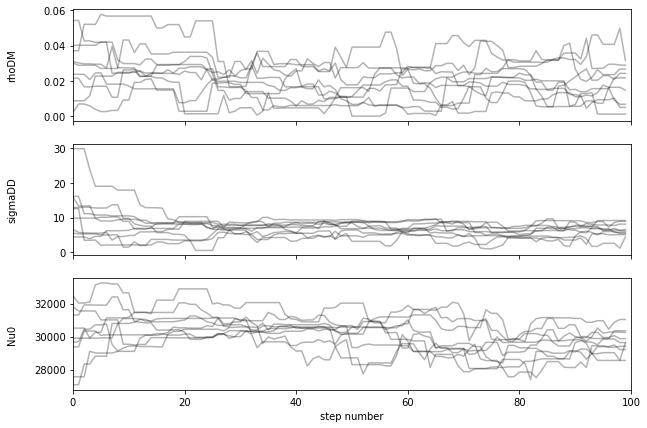

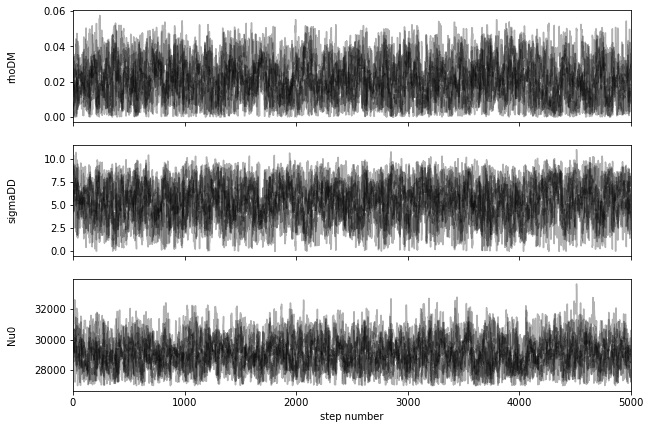

In [150]:
os.environ["OMP_NUM_THREADS"] = "16"
sampler_ = 0
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[priors, data], pool=pool)
    start = time.time()
    state = sampler.run_mcmc(p0, 100, progress=True)
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    print("{0:.1f} times faster than serial".format(serial_time / multi_time))
    labels = ["rhoDM", "sigmaDD", 'hDD', "Nu0", 'zsun']
    plot_chain(sampler, labels)
    sampler.reset()
    sampler.run_mcmc(state, 5000, progress=True)
    plot_chain(sampler, labels)
    sampler_ = sampler

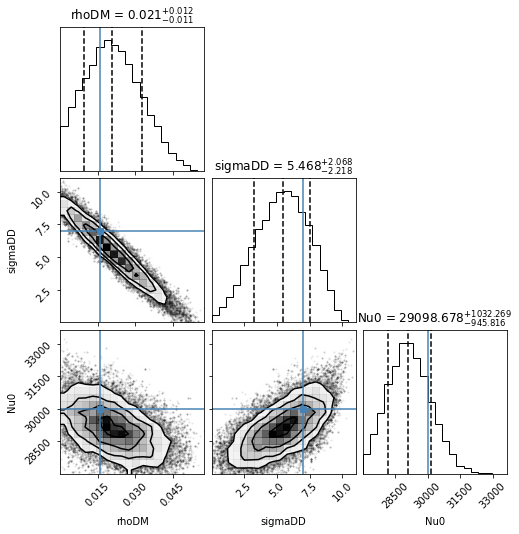

In [155]:
flat_samples = sampler_.get_chain(flat=True)
plot_corners(flat_samples, ["rhoDM", "sigmaDD", "Nu0"], skip=0, truths=[rhoDM, sigmaDD, Nu0])

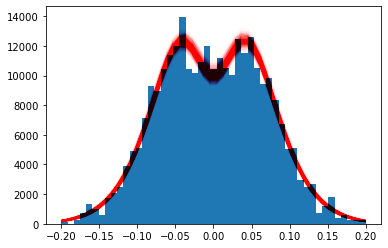

37.58643198013306


In [156]:
model = dict(
    rhoDM=flat_samples[:, 0],
    sigmaDD=flat_samples[:, 1],
    Nu0=flat_samples[:, 2]
)
total = len(flat_samples[:, 0])
data = dict(z_num=z_num, zz=zz)

plot_compare(data, model, total, theta, lambda x, t: log_nu_mod(x, t)+np.log(compz(x)))

# 6. Modelling number density with 7 parameter with emcee and completeness

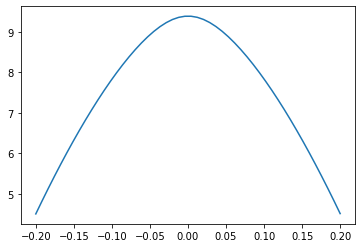

In [214]:
rhos = df_baryon['rho'].to_numpy()
e_rhos = df_baryon['e_rho'].to_numpy()
sigmaz = df_baryon['sigma_z'].to_numpy()
e_sigmaz = df_baryon['e_sigma_z'].to_numpy()

# test the following dark values
rhoDM = 0.016 # Msun/pc^3
sigmaDD = 7 # Msun/pc^2
hDD = 20 # pc
Nu0 = 12000 # pc^-1
zsun = 0.0001 # kpc
sigma_w = 5 # km/s
w0 = -7 # km/s
R = 3.4E-3 # Msun/pc^3
N0 = 200 # (km/s)^-1
theta = dict(rhos=rhos, sigmaz=sigmaz, rhoDM=rhoDM, sigmaDD=sigmaDD, hDD=hDD, Nu0=Nu0, zsun=zsun, R=R, sigma_w=sigma_w, w0=w0, N0=N0)

zz = np.linspace(-0.2, 0.2, 50)
logNu = log_nu_mod(zz, theta)
plt.plot(zz, logNu)

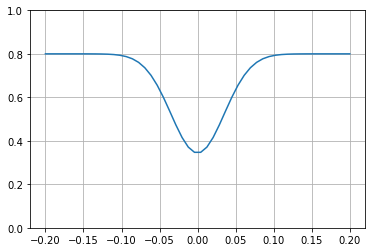

In [222]:
# completeness function
compz = lambda x: -0.04*norm.pdf(x, loc=0, scale=0.035)+0.8

plt.plot(zz, compz(zz))
plt.ylim(0, 1)
plt.grid()

12.72018147307624


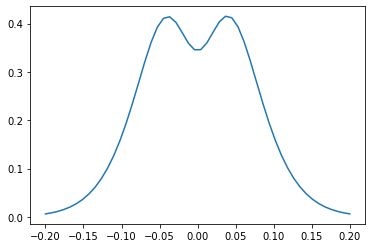

In [223]:
nu_f = lambda zz: np.exp(log_nu_mod(zz, theta))/theta["Nu0"]*compz(zz)

integral_nu, _ = quad(nu_f, -1, 1)
plt.plot(zz, nu_f(zz))
# plt.plot(zz, np.log(nu_f(zz)))
print(1/integral_nu)

In [224]:
def cumulative(z, theta):
    nu_f = lambda zz: np.exp(log_nu_mod(zz, theta))/theta["Nu0"]
    zz = np.linspace(-1,1, 1000)
    integral = simps(nu_f(zz), zz)
    zz = np.array([np.linspace(-1, zs, 1000) for zs in z])
    result = np.array([simps(nu_f(zs), zs) for zs in zz])/integral
    return result

943


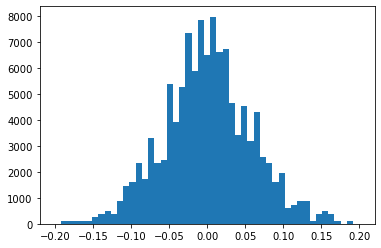

In [225]:
# generate random stars

invers = interp1d(cumulative(zz, theta), zz, kind="cubic", fill_value="extrapolate")
Num = int(Nu0*integral_nu)
rand = np.random.random(Num)
# Nu0_real = Num/integral_nu
print(Num)
z_num = invers(rand)

plt.hist(z_num, bins=zz, weights=np.ones_like(z_num)/(zz[1]-zz[0]))
plt.show()

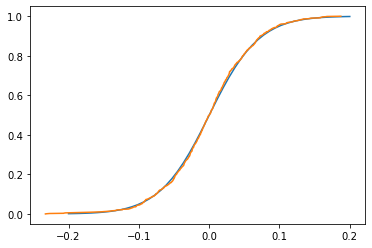

In [226]:
plt.plot(zz, cumulative(zz, theta))
plt.plot(np.sort(z_num), np.linspace(0,1, len(z_num)))

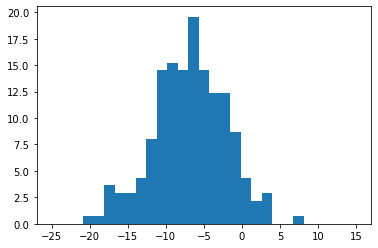

In [227]:
w_num = norm.rvs(loc=w0, scale=sigma_w, size=N0)

ws = np.linspace(-25, 15, 30)

plt.hist(w_num, bins=ws, weights=np.ones_like(w_num)/(ws[1]-ws[0]))
plt.show()

In [228]:
def log_prior(theta, locs, scales):
    args = ('rhoDM', 'sigmaDD', 'hDD', 'Nu0', 'sigma_w', 'w0', 'N0')
    rhoDM, sigmaDD, hDD, Nu0, sigma_w, w0, N0 = itemgetter(*args)(theta)
    args = ('rhoDM_loc', 'sigmaDD_loc', 'hDD_loc', 'Nu0_loc', 'sigma_w_loc', 'w0_loc', 'N0_loc')
    rhoDM_loc, sigmaDD_loc, hDD_loc, Nu0_loc, sigma_w_loc, w0_loc, N0_loc = itemgetter(*args)(locs)
    args = ('rhoDM_scale', 'sigmaDD_scale', 'hDD_scale', 'Nu0_scale', 'sigma_w_scale', 'w0_scale', 'N0_scale')
    rhoDM_scale, sigmaDD_scale, hDD_scale, Nu0_scale, sigma_w_scale, w0_scale, N0_scale = itemgetter(*args)(scales)
    uni_loc = np.array([rhoDM_loc, sigmaDD_loc, hDD_loc, Nu0_loc, sigma_w_loc, w0_loc, N0_loc])
    uni_scale = np.array([rhoDM_scale, sigmaDD_scale, hDD_scale, Nu0_scale, sigma_w_scale, w0_scale, N0_scale])
    uni_val =  rhoDM, sigmaDD, hDD, Nu0, sigma_w, w0, N0
    log_uni = np.sum(uniform.logpdf(uni_val, loc=uni_loc, scale=uni_scale))
    result = (log_uni)
    return result

In [229]:
def log_likelihood(theta, z, w, compz):
    nu_f = lambda x: np.exp(log_nu_mod(x, theta))*compz(x)
    zz = np.linspace(np.min(z), np.max(z), 1000)  
    integral_nu = simps(nu_f(zz), zz)
    log_nu = np.sum(log_nu_mod(z, theta)+np.log(compz(z)))

    mu_f = lambda x: theta['N0']*norm.pdf(x, loc=theta['w0'], scale=theta['sigma_w'])
    integral_mu, _ = quad(mu_f, np.min(w), np.max(w))
    log_mu = np.sum(norm.logpdf(w, loc=theta['w0'], scale=theta['sigma_w'])+np.log(theta['N0']))
    return log_nu-integral_nu+log_mu-integral_mu

In [230]:
def log_posterior(x, priors, data, compz):
    theta = dict(rhos=rhos, sigmaz=sigmaz, rhoDM=x[0], sigmaDD=x[1], hDD=x[2], Nu0=x[3], zsun=zsun, R=R, sigma_w=x[4], w0=x[5], N0=x[6])
    locs, scales = itemgetter('locs', 'scales')(priors)
    z, w = itemgetter('z', 'w')(data)
    log_prior_ = log_prior(theta, locs, scales)
    if not np.isfinite(log_prior_):
        return -np.inf
    log_likelihood_ = log_likelihood(theta, z,w, compz)
    return log_prior_ + log_likelihood_

In [231]:
ndim = 7
nwalkers = ndim*3


rhoDM_loc, rhoDM_scale = 0, 0.06
rhoDM_0 = np.random.uniform(low=rhoDM_loc, high=rhoDM_loc+rhoDM_scale, size=nwalkers)

sigmaDD_loc, sigmaDD_scale = 0, 30
sigmaDD_0 = np.random.uniform(low=sigmaDD_loc, high=sigmaDD_loc+sigmaDD_scale, size=nwalkers)

hDD_loc, hDD_scale = 0, 100
hDD_0 = np.random.uniform(low=hDD_loc, high=hDD_loc+hDD_scale, size=nwalkers)

Nu0_loc, Nu0_scale = 10000, 4000
Nu0_0 = np.random.uniform(low=Nu0_loc, high=Nu0_loc+Nu0_scale, size=nwalkers)

sigma_w_loc, sigma_w_scale = 1, 10
sigma_w_0 = np.random.uniform(low=sigma_w_loc, high=sigma_w_loc+sigma_w_scale, size=nwalkers)

w0_loc, w0_scale = -25, 25
w0_0 = np.random.uniform(low=w0_loc, high=w0_loc+w0_scale, size=nwalkers)

N0_loc, N0_scale = 150, 250
N0_0 = np.random.uniform(low=N0_loc, high=N0_loc+N0_scale, size=nwalkers)

p0 = np.array([rhoDM_0, sigmaDD_0, hDD_0, Nu0_0, sigma_w_0, w0_0, N0_0]).T

In [232]:
locs = dict(rhoDM_loc=rhoDM_loc, sigmaDD_loc=sigmaDD_loc, hDD_loc=hDD_loc, Nu0_loc=Nu0_loc, sigma_w_loc=sigma_w_loc, w0_loc=w0_loc, N0_loc=N0_loc)
scales = dict(rhoDM_scale=rhoDM_scale, sigmaDD_scale=sigmaDD_scale, hDD_scale=hDD, Nu0_scale=Nu0_scale, sigma_w_scale=sigma_w_scale, w0_scale=w0_scale, N0_scale=N0_scale)
priors = dict(locs=locs, scales=scales)
data = dict(z=z_num, w=w_num)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[priors, data, compz])

In [233]:
state = sampler.run_mcmc(p0, 5000, progress=True)
state

  0%|          | 0/5000 [00:00<?, ?it/s]/home2/s20321005/.conda/envs/vaex2/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▏         | 89/5000 [00:16<12:54,  6.34it/s]/home2/s20321005/Thesis-Project/utils.py:137: RuntimeWarning: overflow encountered in cosh
  return 1/np.cosh(x)
100%|██████████| 5000/5000 [15:08<00:00,  5.50it/s]


State([[ 2.15649867e-03  1.54342267e+01  1.20412068e+01  1.39510274e+04
   5.20185532e+00 -6.71674351e+00  1.91756214e+02]
 [ 3.47404910e-02  1.34590799e+01  8.34921574e+01  1.22132577e+04
   2.17506618e+00 -1.05466306e+01  1.50959078e+02]
 [ 1.18626324e-03  1.49031319e+01  1.29088839e+01  1.39714924e+04
   5.23476759e+00 -6.54649273e+00  2.15337682e+02]
 [ 1.78518399e-02  1.28157485e+01  9.44805624e+01  1.35943997e+04
   6.02342760e+00 -2.18410831e+01  1.98087758e+02]
 [ 2.90431293e-02  6.04884756e+00  9.70689278e+01  1.25781899e+04
   6.90391005e+00 -2.30868415e+01  3.39390651e+02]
 [ 7.47176923e-03  1.46671130e+01  1.51676359e+01  1.39951304e+04
   5.14150367e+00 -6.76662279e+00  2.08434172e+02]
 [ 7.78191691e-04  2.50534237e+01  5.06040008e+01  1.08089244e+04
   3.20698263e+00 -2.00843782e+00  2.11798367e+02]
 [ 2.14777827e-02  2.08558599e+01  6.40547283e+01  1.04775548e+04
   7.95419947e+00 -6.21859933e+00  2.54889106e+02]
 [ 4.81799620e-02  2.06611584e+00  5.62558583e+01  1.09554

Text(0.5, 0, 'step number')

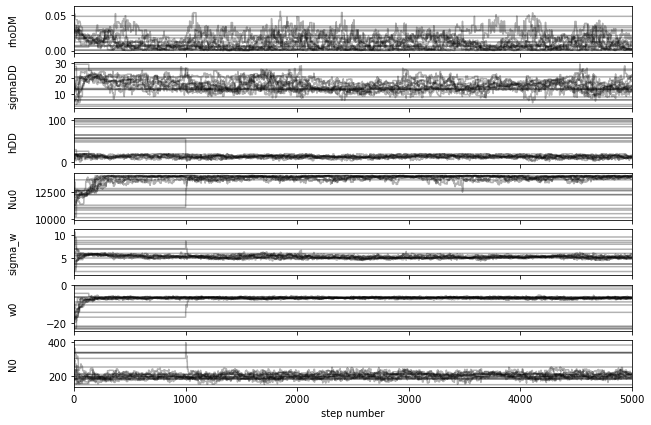

In [234]:
fig, axes = plt.subplots(7, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["rhoDM", "sigmaDD", "hDD", "Nu0", "sigma_w", "w0", "N0"]
for i in range(7):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [175]:
sampler.reset()
sampler.run_mcmc(state, 10000, progress=True)

  0%|          | 0/10000 [00:00<?, ?it/s]/home2/s20321005/.conda/envs/vaex2/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 67/10000 [00:17<37:07,  4.46it/s]  /home2/s20321005/Thesis-Project/utils.py:137: RuntimeWarning: overflow encountered in cosh
  return 1/np.cosh(x)
100%|██████████| 10000/10000 [31:46<00:00,  5.24it/s]


State([[ 5.26455478e-02  7.48277174e+00  7.47803950e+01  1.22980218e+04
   9.06699367e+00 -2.32708866e+01  2.37750368e+02]
 [ 1.14746495e-02  2.10282517e+01  4.74648427e+01  1.14114151e+04
   8.93142079e+00 -4.64676593e+00  3.82168245e+02]
 [ 1.79785826e-02  2.04671282e+00  5.81869737e+01  1.24667681e+04
   6.82428603e+00 -6.28861445e+00  2.62135320e+02]
 [ 7.79049033e-04  1.44014875e+01  1.51085640e+01  1.34608947e+04
   5.22706505e+00 -6.96035589e+00  2.24927326e+02]
 [ 7.19688494e-03  1.45579827e+01  1.89855800e+01  1.36393035e+04
   5.20558242e+00 -6.85149862e+00  1.79135720e+02]
 [ 2.14466985e-02  1.25381003e+01  1.53523806e+01  1.34262523e+04
   5.41943655e+00 -6.92389494e+00  1.96374705e+02]
 [ 2.03815500e-02  7.35005282e+00  1.23990922e+01  1.32343986e+04
   4.82258504e+00 -6.63601535e+00  2.00600026e+02]
 [ 1.67400692e-02  1.25632263e+01  1.69200798e+01  1.34152360e+04
   5.22254393e+00 -6.47673641e+00  2.30199420e+02]
 [ 5.73423784e-02  1.52926021e+00  4.64958103e+01  1.14005

Text(0.5, 0, 'step number')

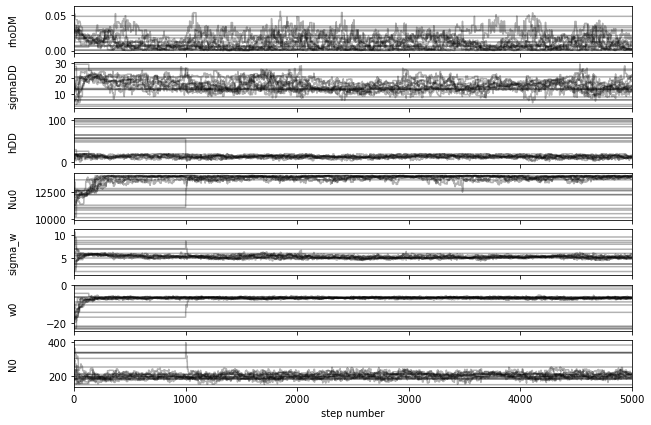

In [235]:
fig, axes = plt.subplots(7, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["rhoDM", "sigmaDD", "hDD", "Nu0", "sigma_w", "w0", "N0"]
for i in range(7):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [236]:
flat_samples = sampler.get_chain(flat=True)
flat_samples

array([[ 5.93538105e-02,  6.97101411e+00,  2.46375015e+00, ...,
         7.74787015e+00, -1.00311364e+01,  1.73883722e+02],
       [ 3.47404910e-02,  1.34590799e+01,  8.34921574e+01, ...,
         2.17506618e+00, -1.05466306e+01,  1.50959078e+02],
       [ 2.51361501e-02,  1.21997565e+01,  4.38105615e-01, ...,
         6.52787244e+00, -1.75650786e+01,  2.13635296e+02],
       ...,
       [ 2.44139016e-03,  1.79696592e+01,  1.37900434e+01, ...,
         5.36468365e+00, -6.53852564e+00,  2.17300835e+02],
       [ 2.73832737e-03,  1.49395161e+01,  1.59774281e+01, ...,
         5.16778133e+00, -7.13484682e+00,  2.17303125e+02],
       [ 2.75714854e-02,  3.15054991e+00,  8.95379748e+01, ...,
         8.73734124e+00, -8.65549044e-01,  3.37306588e+02]])

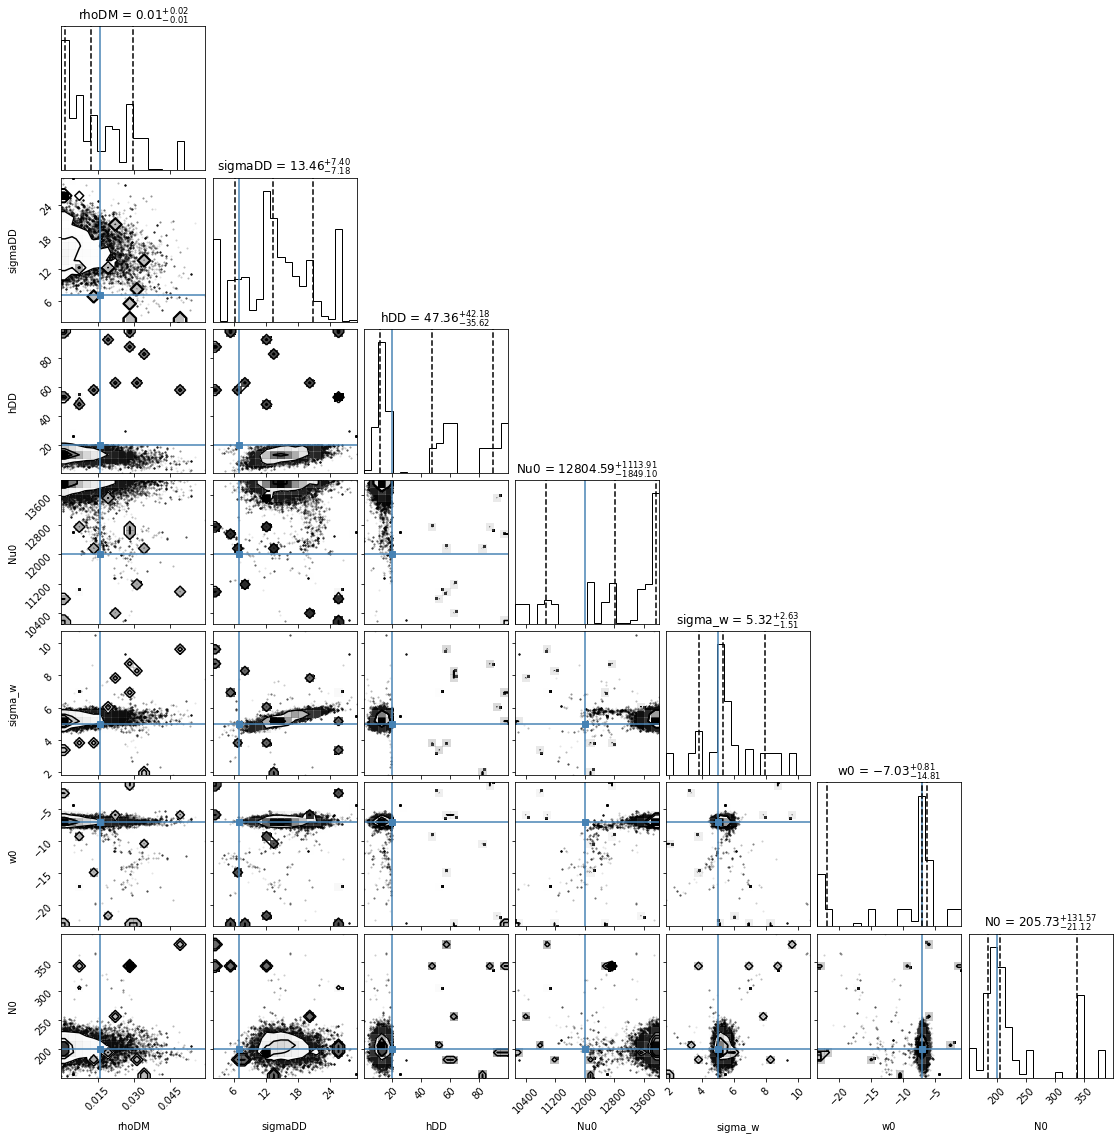

In [237]:
fig = corner.corner(
    flat_samples, labels=["rhoDM", "sigmaDD", "hDD", "Nu0", "sigma_w", "w0", "N0"],
    truths=[rhoDM, sigmaDD, hDD, Nu0, sigma_w, w0, N0],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True, title_kwargs={"fontsize": 12},
)

In [239]:
# save to dataframe
dict_mcmc = {
    "rhoDM": flat_samples[:, 0],
    "sigmaDD": flat_samples[:, 1],
    "hDD": flat_samples[:, 2], 
    "logNu0": flat_samples[:, 3], 
    "sigma_w": flat_samples[:, 4], 
    "w0": flat_samples[:, 5], 
    "N0": flat_samples[:, 6]
}
df_mcmc = vaex.from_dict(dict_mcmc)
df_mcmc

#,rhoDM,sigmaDD,hDD,logNu0,sigma_w,w0,N0
0,0.05935381051201771,6.971014111370052,2.463750148103891,12920.403532761396,7.747870145525342,-10.031136414390708,173.88372169482238
1,0.034740491037723226,13.45907989030272,83.4921573615206,12213.257687487985,2.1750661765893913,-10.546630574140266,150.95907788153593
2,0.025136150096252943,12.19975653366957,0.4381056153389684,12431.058617940515,6.527872436262166,-17.56507856965751,213.63529581973242
3,0.017851839850127,12.815748466495911,94.48056239937424,13594.399672575484,6.0234275973435185,-21.841083071052427,198.08775789092502
4,0.029043129276510333,6.048847560854717,97.06892779419837,12578.189939721591,6.9039100504791175,-23.08684151074544,339.390651318175
...,...,...,...,...,...,...,...
"104,995",0.007737844229871593,12.864129829278717,12.515472598147788,13915.322972221533,5.113371474763986,-6.733083644515643,211.8432088335222
"104,996",0.006131302461432497,12.845861646357145,47.35887620753545,12796.623085624404,3.7228967065724294,-8.923681990212025,341.1103580643892
"104,997",0.0024413901638342264,17.96965916964963,13.790043421917217,13889.548552934906,5.364683654421943,-6.538525638249662,217.30083484947286
"104,998",0.0027383273698465263,14.93951609123415,15.977428114409403,13995.494408092842,5.167781331782876,-7.134846815379609,217.30312503452924


# 7. Modelling number density with 33 parameters with emcee and completeness

In [ ]:
rhos = df_baryon['rho'].to_numpy()
e_rhos = df_baryon['e_rho'].to_numpy()
sigmaz = df_baryon['sigma_z'].to_numpy()
e_sigmaz = df_baryon['e_sigma_z'].to_numpy()

# test the following dark values
rhoDM = 0.016 # Msun/pc^3
sigmaDD = 7 # Msun/pc^2
hDD = 20 # pc
Nu0 = 12000 # pc^-1
zsun = 0.0001 # kpc
sigma_w = 5 # km/s
w0 = -7 # km/s
R = 3.4E-3 # Msun/pc^3
N0 = 200 # (km/s)^-1
theta = dict(rhos=rhos, sigmaz=sigmaz, rhoDM=rhoDM, sigmaDD=sigmaDD, hDD=hDD, Nu0=Nu0, zsun=zsun, R=R, sigma_w=sigma_w, w0=w0, N0=N0)

zz = np.linspace(-0.2, 0.2, 50)
logNu = log_nu_mod(zz, theta)
plt.plot(zz, logNu)

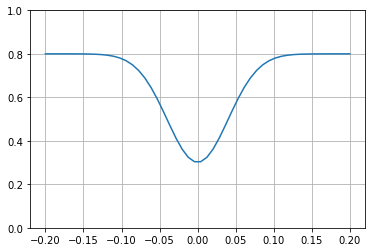

In [191]:
# completeness function
compz = lambda x: -0.05*norm.pdf(x, loc=0, scale=0.04)+0.8

plt.plot(zz, compz(zz))
plt.ylim(0, 1)
plt.grid()

13.875547856825193


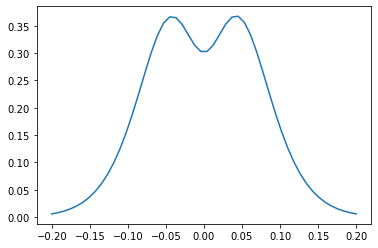

In [192]:
nu_f = lambda zz: np.exp(log_nu_mod(zz, theta))/theta["Nu0"]*compz(zz)

integral_nu, _ = quad(nu_f, -1, 1)
plt.plot(zz, nu_f(zz))
# plt.plot(zz, np.log(nu_f(zz)))
print(1/integral_nu)

In [193]:
def cumulative(z, theta):
    nu_f = lambda zz: np.exp(log_nu_mod(zz, theta))/theta["Nu0"]
    zz = np.linspace(-1,1, 1000)
    integral = simps(nu_f(zz), zz)
    zz = np.array([np.linspace(-1, zs, 1000) for zs in z])
    result = np.array([simps(nu_f(zs), zs) for zs in zz])/integral
    return result

864


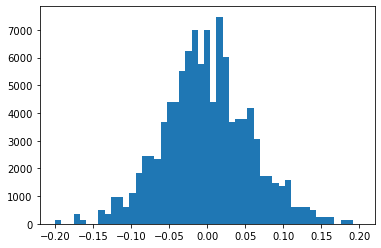

In [194]:
# generate random stars

invers = interp1d(cumulative(zz, theta), zz, kind="cubic", fill_value="extrapolate")
Num = int(Nu0*integral_nu)
rand = np.random.random(Num)
# Nu0_real = Num/integral_nu
print(Num)
z_num = invers(rand)

plt.hist(z_num, bins=zz, weights=np.ones_like(z_num)/(zz[1]-zz[0]))
plt.show()

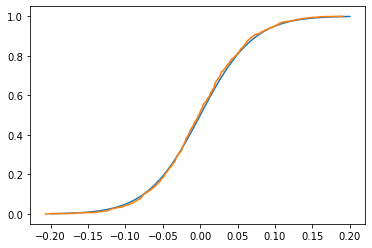

In [195]:
plt.plot(zz, cumulative(zz, theta))
plt.plot(np.sort(z_num), np.linspace(0,1, len(z_num)))

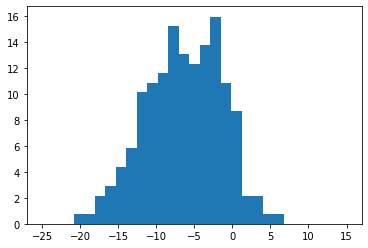

In [196]:
w_num = norm.rvs(loc=w0, scale=sigma_w, size=N0)

ws = np.linspace(-25, 15, 30)

plt.hist(w_num, bins=ws, weights=np.ones_like(w_num)/(ws[1]-ws[0]))
plt.show()

In [197]:
def log_prior(theta, locs, scales):
    args = ('rhos', 'sigmaz', 'rhoDM', 'sigmaDD', 'hDD', 'Nu0', 'zsun', 'R', 'sigma_w', 'w0', 'N0')
    rhos, sigmaz, rhoDM, sigmaDD, hDD, Nu0, zsun, R, sigma_w, w0, N0 = itemgetter(*args)(theta)
    args = ('rhos_loc', 'sigmaz_loc', 'rhoDM_loc', 'sigmaDD_loc',  'hDD_loc', 'Nu0_loc', 
            'zsun_loc', 'R_loc', 'sigma_w_loc', 'w0_loc', 'N0_loc')
    rhos_loc, sigmaz_loc, rhoDM_loc, sigmaDD_loc, hDD_loc, Nu0_loc, zsun_loc, R_loc, sigma_w_loc, w0_loc, N0_loc = itemgetter(*args)(locs)
    args = ('rhos_scale', 'sigmaz_scale', 'rhoDM_scale', 'sigmaDD_scale', 'hDD_scale', 'Nu0_scale',
            'zsun_scale', 'R_scale', 'sigma_w_scale', 'w0_scale', 'N0_scale')
    rhos_scale, sigmaz_scale, rhoDM_scale, sigmaDD_scale, hDD_scale, Nu0_scale, zsun_scale, R_scale, sigma_w_scale, w0_scale, N0_scale = itemgetter(*args)(scales)
    uni_loc = np.array([rhoDM_loc, sigmaDD_loc, hDD_loc, Nu0_loc, zsun_loc, sigma_w_loc, w0_loc, N0_loc])
    uni_scale = np.array([rhoDM_scale, sigmaDD_scale, hDD_scale, Nu0_scale, zsun_scale, sigma_w_scale, w0_scale, N0_scale])
    uni_val = rhoDM, sigmaDD, hDD, Nu0, zsun, sigma_w, w0, N0
    log_uni = np.sum(uniform.logpdf(uni_val, loc=uni_loc, scale=uni_scale))
    result = (np.sum(norm.logpdf(rhos, loc=rhos_loc, scale=rhos_scale))
            +np.sum(norm.logpdf(sigmaz, loc=sigmaz_loc, scale=sigmaz_scale))
            +norm.logpdf(R, loc=R_loc, scale=R_scale)
            +log_uni)
    return result

In [199]:
def log_likelihood(theta, z, w, compz):
    nu_f = lambda x: np.exp(log_nu_mod(x, theta))*compz(x)
    zz = np.linspace(np.min(z), np.max(z), 1000)  
    integral_nu = simps(nu_f(zz), zz)
    log_nu = np.sum(log_nu_mod(z, theta)+np.log(compz(z)))

    mu_f = lambda x: theta['N0']*norm.pdf(x, loc=theta['w0'], scale=theta['sigma_w'])
    integral_mu, _ = quad(mu_f, np.min(w), np.max(w))
    log_mu = np.sum(norm.logpdf(w, loc=theta['w0'], scale=theta['sigma_w'])+np.log(theta['N0']))
    return log_nu-integral_nu+log_mu-integral_mu

In [200]:
def log_posterior(x, priors, data, compz):
  theta = dict(rhos=x[0:12], sigmaz=x[12:24], rhoDM=x[24], sigmaDD=x[25], hDD=x[26], Nu0=x[27], zsun=x[28], R=x[29], sigma_w=x[30], w0=x[31], N0=x[32])
  locs, scales = itemgetter('locs', 'scales')(priors)
  z, w = itemgetter('z', 'w')(data)
  log_prior_ = log_prior(theta, locs, scales)
  if not np.isfinite(log_prior_):
      return -np.inf
  log_likelihood_ = log_likelihood(theta, z, w, compz)
  return log_prior_ + log_likelihood_

In [207]:
# example mcmc
# np.random.seed(42)
ndim = 33
nwalkers = ndim*3

rhos_0 = np.random.normal(loc=rhos, scale=e_rhos, size=(nwalkers, 12))
sigmaz_0 = np.random.normal(loc=sigmaz, scale=e_sigmaz, size=(nwalkers, 12))

rhoDM_loc, rhoDM_scale = 0, 0.06
rhoDM_0 = np.random.uniform(low=rhoDM_loc, high=rhoDM_loc+rhoDM_scale, size=nwalkers)

sigmaDD_loc, sigmaDD_scale = 0, 30
sigmaDD_0 = np.random.uniform(low=sigmaDD_loc, high=sigmaDD_loc+sigmaDD_scale, size=nwalkers)

hDD_loc, hDD_scale = 0, 100
hDD_0 = np.random.uniform(low=hDD_loc, high=hDD_loc+hDD_scale, size=nwalkers)


Nu0_loc, Nu0_scale = 10000, 4000
Nu0_0 = np.random.uniform(low=Nu0_loc, high=Nu0_loc+Nu0_scale, size=nwalkers)

zsun_loc, zsun_scale = -0.05, 0.10
zsun_0 = np.random.uniform(low=zsun_loc, high=zsun_loc+zsun_scale, size=nwalkers)

R_loc, R_scale = 3.4E-3, 0.6E-3
R_0 = np.random.normal(loc=R_loc, scale=R_scale, size=nwalkers)

# sigma_range = dict(A=9, F=20, G=20)
sigma_w_loc, sigma_w_scale = 1, 10
sigma_w_0 = np.random.uniform(low=sigma_w_loc, high=sigma_w_loc+sigma_w_scale, size=nwalkers)

w0_loc, w0_scale = -25, 50
w0_0 = np.random.uniform(low=w0_loc, high=w0_loc+w0_scale, size=nwalkers)

N0_loc, N0_scale = 150, 250
N0_0 = np.random.uniform(low=N0_loc, high=N0_loc+N0_scale, size=nwalkers)

p0 = np.array([*rhos_0.T, *sigmaz_0.T, rhoDM_0, sigmaDD_0, hDD_0, Nu0_0, zsun_0, R_0, sigma_w_0, w0_0, N0_0]).T

In [208]:
locs = dict(rhos_loc=rhos, sigmaz_loc=sigmaz, rhoDM_loc=rhoDM_loc, sigmaDD_loc=sigmaDD_loc, hDD_loc=hDD_loc, 
            Nu0_loc=Nu0_loc, zsun_loc=zsun_loc, R_loc=R_loc, sigma_w_loc=sigma_w_loc, w0_loc=w0_loc, N0_loc=N0_loc)
scales = dict(rhos_scale=e_rhos, sigmaz_scale=e_sigmaz, rhoDM_scale=rhoDM_scale, sigmaDD_scale=sigmaDD_scale, 
              hDD_scale=hDD_scale, Nu0_scale=Nu0_scale, zsun_scale=zsun_scale, R_scale=R_scale, 
              sigma_w_scale=sigma_w_scale, w0_scale=w0_scale, N0_scale=N0_scale)
priors = dict(locs=locs, scales=scales)

data = dict(z=z_num, w=w_num)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[priors, data, compz])

In [209]:
state = sampler.run_mcmc(p0, 200, progress=True)
state

 28%|██▊       | 56/200 [01:35<04:04,  1.70s/it]/home2/s20321005/Thesis-Project/utils.py:137: RuntimeWarning: overflow encountered in cosh
  return 1/np.cosh(x)
100%|██████████| 200/200 [06:59<00:00,  2.10s/it]


State([[ 1.29521527e-02  2.57619285e-02  7.89183750e-03 ...  5.54373734e+00
  -5.94916633e+00  2.54536671e+02]
 [ 1.15624178e-02  2.32302685e-02  7.98379559e-03 ...  5.73118581e+00
  -6.75222104e+00  1.95519618e+02]
 [ 1.66394524e-02  2.13445047e-02  6.62287670e-03 ...  6.25629729e+00
  -6.98486411e+00  2.09941318e+02]
 ...
 [ 1.37429109e-02  2.31766125e-02  6.92701089e-03 ...  6.44672650e+00
  -5.58640186e+00  2.25446691e+02]
 [ 9.89210472e-03  1.97579576e-02  6.37934244e-03 ...  4.85293722e+00
  -6.05933192e+00  1.90035405e+02]
 [ 1.35139365e-02  3.83526190e-02  6.50209339e-03 ...  4.49358816e+00
  -6.07182739e+00  2.08366906e+02]], log_prob=[6470.04876626 6480.63782524 6477.5912017  6473.37228462 6476.35418719
 6471.39148762 6478.44797237 6469.69913084 6474.40070061 6472.28542836
 6473.72649925 6477.16679201 6471.71561041 6478.6321985  6471.53381933
 6470.56197584 6464.68975375 6473.94150324 6465.63029121 6475.08323078
 6471.94320814 6477.7590684  6478.03830193 6471.61501752 6474.84

Text(0.5, 0, 'step number')

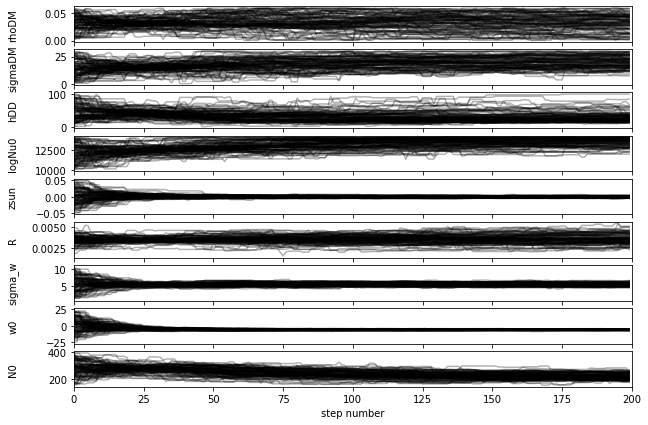

In [212]:
fig, axes = plt.subplots(9, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["rhoDM", "sigmaDM", "hDD", "Nu0", "zsun", "R", "sigma_w", "w0", "N0"]
for i in range(9):
    ax = axes[i]
    ax.plot(samples[:, :, 24+i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [213]:
sampler.reset()
sampler.run_mcmc(state, 10000, progress=True)

  0%|          | 40/10000 [02:18<8:51:00,  3.20s/it] /home2/s20321005/Thesis-Project/utils.py:137: RuntimeWarning: overflow encountered in cosh
  return 1/np.cosh(x)
  0%|          | 44/10000 [02:32<9:17:16,  3.36s/it]Traceback (most recent call last):
  File "/home2/s20321005/.conda/envs/vaex2/lib/python3.9/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-200-2f5f16591260>", line 8, in log_posterior
    log_likelihood_ = log_likelihood(theta, z, w, compz)
  File "<ipython-input-199-c5db0d407d57>", line 4, in log_likelihood
    integral_nu = simps(nu_f(zz), zz)
  File "<ipython-input-199-c5db0d407d57>", line 2, in <lambda>
    nu_f = lambda x: np.exp(log_nu_mod(x, theta))*compz(x)
  File "/home2/s20321005/Thesis-Project/utils.py", line 166, in log_nu_mod
    us = odeint(f, y0, zs, args=(rhos, sigmaz, rhoDM, sigmaDD, hDD, R))
  File "/home2/s20321005/.conda/envs/vaex2/lib/python3.9/site-packages/scipy/integrat

emcee: Exception while calling your likelihood function:
  params: [ 1.14353260e-02  4.07923273e-02  9.26214774e-03  5.14638214e-04
  7.21106192e-04  1.55982810e-03  1.97497645e-03  1.57222801e-03
  7.18439381e-03  1.49897049e-02  6.07441998e-03  9.28068616e-04
  3.84843564e+00  6.78742990e+00  1.53165814e+01  4.03806822e+01
  2.08324841e+01  5.67621621e+00  1.91143046e+01  1.57078680e+01
  2.26754707e+01  2.42307489e+01  5.19937276e+00  2.33775062e+01
  5.63656620e-02  2.22088686e+01  2.05665023e+01  1.33558611e+04
  3.30303485e-03  6.14994293e-03  5.91399897e+00 -5.17038014e+00
  2.03247671e+02]
  args: [{'locs': {'rhos_loc': array([0.0104, 0.0277, 0.0073, 0.0005, 0.0006, 0.0018, 0.0018, 0.0029,
       0.0072, 0.0216, 0.0056, 0.0015]), 'sigmaz_loc': array([ 3.7,  7.1, 22.1, 39. , 15.5,  7.5, 12. , 18. , 18.5, 18.5, 20. ,
       20. ]), 'rhoDM_loc': 0, 'sigmaDD_loc': 0, 'hDD_loc': 0, 'Nu0_loc': 10000, 'zsun_loc': -0.05, 'R_loc': 0.0034, 'sigma_w_loc': 1, 'w0_loc': -25, 'N0_loc': 150},

KeyboardInterrupt: 

In [ ]:
fig, axes = plt.subplots(9, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["rhoDM", "sigmaDM", "hDD", "Nu0", "zsun", "R", "sigma_w", "w0", "N0"]
for i in range(9):
    ax = axes[i]
    ax.plot(samples[:, :, 24+i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [ ]:
flat_samples = sampler.get_chain(flat=True)
flat_samples

In [ ]:
fig = corner.corner(
    flat_samples, labels=["rhoDM", "sigmaDD", "hDD", "Nu0", "sigma_w", "w0", "N0"],
    truths=[rhoDM, sigmaDD, hDD, Nu0, sigma_w, w0, N0],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True, title_kwargs={"fontsize": 12},
)

In [ ]:
# save to dataframe
dict_mcmc = {
    "rho1": flat_samples[:, 0],
    "rho2": flat_samples[:, 1],
    "rho3": flat_samples[:, 2],
    "rho4": flat_samples[:, 3],
    "rho5": flat_samples[:, 4],
    "rho6": flat_samples[:, 5],
    "rho7": flat_samples[:, 6],
    "rho8": flat_samples[:, 7],
    "rho9": flat_samples[:, 8],
    "rho10": flat_samples[:, 9],
    "rho11": flat_samples[:, 10],
    "rho12": flat_samples[:, 11],
    "sigmaz1": flat_samples[:, 12],
    "sigmaz2": flat_samples[:, 13],
    "sigmaz3": flat_samples[:, 14],
    "sigmaz4": flat_samples[:, 15],
    "sigmaz5": flat_samples[:, 16],
    "sigmaz6": flat_samples[:, 17],
    "sigmaz7": flat_samples[:, 18],
    "sigmaz8": flat_samples[:, 19],
    "sigmaz9": flat_samples[:, 20],
    "sigmaz10": flat_samples[:, 21],
    "sigmaz11": flat_samples[:, 22],
    "sigmaz12": flat_samples[:, 23],
    "rhob": np.sum(flat_samples[:, 0:12], axis=1),
    "rhoDM": flat_samples[:, 24],
    "sigmaDD": flat_samples[:, 25],
    "hDD": flat_samples[:, 26], 
    "logNu0": flat_samples[:, 27], 
    "zsun": flat_samples[:, 28], 
    "R": flat_samples[:, 29], 
    "sigma_w": flat_samples[:, 30], 
    "w0": flat_samples[:, 31], 
    "N0": flat_samples[:, 32]
}
df_mcmc = vaex.from_dict(dict_mcmc)
df_mcmc

In [240]:
data_mcmc_dir = join(root_data_dir, "MCMC")
df = vaex.open(join(data_mcmc_dir, "model.hdf5"))
df

#,rho1,rho2,rho3,rho4,rho5,rho6,rho7,rho8,rho9,rho10,rho11,rho12,sigmaz1,sigmaz2,sigmaz3,sigmaz4,sigmaz5,sigmaz6,sigmaz7,sigmaz8,sigmaz9,sigmaz10,sigmaz11,sigmaz12,rhob,rhoDM,sigmaDD,hDD,logNu0,zsun,R,sigma_w,w0,N0
0,0.008841195690531255,0.027307180807713643,0.007134886183549887,0.0004840085728542994,0.0006039013844975987,0.0017685369991742987,0.0018818888335673345,0.0025731668816709116,0.006807793318957485,0.022891172335438317,0.005453280519642505,0.001414692248344314,3.744244166471942,7.2899383343923505,22.310491472929776,36.712316457618385,16.32572005359354,7.7941443782635575,12.99576404059815,17.967683755282017,18.601843310706798,17.647405499133733,21.98874915125961,18.594109715687562,0.08716170377594185,0.027597675515542586,14.20227052866235,46.97665359928264,12309.60551829019,-0.004457103401869106,0.002952507663963288,5.709224627739469,7.556240982383919,289.8811282233869
1,0.01160686805261289,0.030491560745559386,0.006904959668179812,0.0005104084318219836,0.0005797462060251996,0.0018035476890431884,0.0018125316973698527,0.0029770442143291524,0.007115730865437411,0.02102275684337493,0.005721291193468416,0.00154502782102771,3.609861305932095,7.073134337809162,23.863442661236753,38.955433598537226,15.151591792093404,6.973021612017891,12.212514147666857,17.082302790678526,18.8100705507385,20.81875955134132,21.09060729998212,18.204141257029082,0.09209147342824993,0.03983370016086884,18.0072521824752,53.085171643110456,12046.070317842816,-0.0030260649315569585,0.0032068418291427716,6.473325848490982,5.3353052732330415,284.2763382354704
2,0.015095337703365342,0.033312700654699774,0.0069022995718365995,0.0004974119940251368,0.0006401564949331215,0.0018412421550938359,0.001746465127738958,0.0028541697808813103,0.00854515688865863,0.02358813057972217,0.004788591320469664,0.0012892655483825836,3.8594666146373013,7.736388960208259,22.088301053876645,39.86447790133632,15.769541620302078,5.7834225566967445,12.110805084163248,16.46686440947745,18.75357852223358,25.45330943095886,20.430715487722377,21.011122534360698,0.10110092781980713,0.0292906613481585,17.55979471104907,28.316013569844408,12606.909565752589,-0.0011389774055353998,0.004708487776155012,6.105843658111151,-7.087629699105665,339.3697640824588
3,0.008294805968084398,0.031432475478850405,0.007023940512787304,0.000498740441167228,0.0005846796514491698,0.001759794929527934,0.00191641352665702,0.00310806122453072,0.007651540106057041,0.017831762129474783,0.005487860684479309,0.001828575613292971,3.531327233616876,6.878573229669665,21.33551651890908,40.6951348949303,16.105008847426824,5.814538114072301,10.599173317947068,16.600211444879154,18.162445134291044,24.186578796164905,21.158392192969114,19.075722701335206,0.08741865026635828,0.022589134161457875,14.378730477307943,73.04902604870036,12695.878701634505,-0.0022356554505064625,0.0035050990491011,4.530410423896116,-7.414706408347817,290.3484216905276
4,0.010435808605100934,0.028096846094370253,0.006822812665705587,0.0004951423249804531,0.0006304448486459585,0.001912225918305042,0.0017737838255942598,0.0027528883763881574,0.007326368011554538,0.022955912777626427,0.00519736446062023,0.001532435674714419,3.5678648069630428,6.928970550781916,21.506123782223742,35.743976750942416,14.383211268033895,7.030444363283043,10.609095664747516,19.46249651363197,16.47988498808943,18.606698475137062,17.28684740768621,20.226503521659982,0.08993203358360627,0.037938857783955636,11.351019478138921,53.634344482103494,12010.509482729525,0.018112658333202004,0.003534774667183268,5.266450596955664,-2.314059728940283,273.7515562766799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,0.010541576312224988,0.029549579268940446,0.007092900595633457,0.0005033491442086689,0.0006106510149383644,0.0017996395827446817,0.0017989140480271291,0.0028419864257127263,0.007067704632670145,0.02209060772052469,0.0054694263393044494,0.0014823972912047449,3.663675023508105